# Activity explorer
This piece of code is to explore the function of going through the synthetic population and grabbing an appropriate activity profile for the individual

# Import Libraries

In [1]:
import sys
sys.path.append('../')  # Add the parent directory to the system path

import tripsender.nhts as nhts
# Data manipulation
import pandas as pd
import numpy as np
import json
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical analysis
from scipy.stats import gamma, chi2, invgauss
from sklearn.mixture import GaussianMixture

# Load and clean data

In [2]:
# Read data
nhts_data = pd.read_csv('../data/raw/NHTS/Data_RVU_2017_GBG_utanEXTRA.csv', sep=';')
# Preprocess data
df_persons = nhts.preprocess_data(nhts_data,unique_trips_only = True)
df_activity = nhts.preprocess_data(nhts_data,unique_trips_only = False)

c:\Users\ssanjay\AppData\Local\Continuum\anaconda3\envs\tripsender\lib\site-packages\IPython\core\interactiveshell.py:3266: DtypeWarning: Columns (34,41,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Defining some helper functions

In [3]:
# Function to compute activity duration for a given purpose
def compute_activity_duration(df, purpose):
    """
    Compute activity duration for a given purpose.

    Parameters:
        df (DataFrame): Input DataFrame containing activity data.
        purpose (str): The purpose of the activity to compute duration for.

    Returns:
        DataFrame: A DataFrame with columns 'id', 'duration', and 'activity'.
    """
    subset_df = df[df['purpose'] == purpose].copy()
    subset_df['activity_duration_minutes'] = (subset_df['next_start_time'] - subset_df['end_time']) / np.timedelta64(1, 'm')
    
    # Remove negative durations
    subset_df = subset_df[subset_df['activity_duration_minutes'] >= 0]

    # Remove outliers
    Q1 = subset_df['activity_duration_minutes'].quantile(0.25)
    Q3 = subset_df['activity_duration_minutes'].quantile(0.75)
    IQR = Q3 - Q1
    subset_df = subset_df[~((subset_df['activity_duration_minutes'] < (Q1 - 1.5 * IQR)) |
                            (subset_df['activity_duration_minutes'] > (Q3 + 1.5 * IQR)))]

    # Ensure duration is between 1 minute and 1080 minutes (18 hours)
    subset_df = subset_df[(subset_df['activity_duration_minutes'] >= 1) & (subset_df['activity_duration_minutes'] <= 1080)]
    


    # Convert minutes to hours
    subset_df['activity_duration_hours'] = subset_df['activity_duration_minutes'] / 60
    
    # Create the final dataframe for this purpose
    df_duration = subset_df[['id', 'activity_duration_hours']].copy()
    df_duration.columns = ['id', 'duration']
    df_duration['activity'] = purpose
    
    return df_duration

# Mapping of activities to their assumed distributions
distribution_mapping = {
    'Work': 'trimodal',
    'Leisure': 'gamma',
    'Healthcare': 'invgauss',
    'Grocery shopping': 'gamma',
    'Other shopping': 'gamma',
    'Education': 'bimodal',
    'Travel': 'invgauss',
    'Other': 'invgauss'
}

# Function to fit and plot distribution for a given purpose
def fit_and_plot(activity_df, purpose, color):
    """
    Fit and plot distribution for a given purpose.

    Parameters:
        activity_df (DataFrame): DataFrame containing activity duration data.
        purpose (str): The purpose of the activity.
        color (str): Color for the plot.

    Returns:
        tuple: Distribution parameters.
    """
    plt.figure(figsize=(15, 5))
    
    # Get data and fit
    data = activity_df['duration'].fillna(0).values.reshape(-1, 1)  # reshaping as GMM expects 2D array
    
    # Hist data
    y, x = np.histogram(data, bins=30, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    pdf = None  # Initialize pdf as None

    if distribution_mapping.get(purpose) == 'gamma':
        params = gamma.fit(data.ravel())
        pdf = gamma.pdf(x, *params)
        
    elif distribution_mapping.get(purpose) == 'chi2':
        dof, loc, scale = chi2.fit(data.ravel(), floc=0)
        pdf = chi2.pdf(x, dof, loc, scale)
        params = (dof, loc, scale)
    elif distribution_mapping.get(purpose) == 'bimodal':
        gmm = GaussianMixture(n_components=2)
        gmm.fit(data)
        pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
        params = (gmm.weights_, gmm.means_, gmm.covariances_ )
    elif distribution_mapping.get(purpose) == 'trimodal':
        gmm = GaussianMixture(n_components=3)
        gmm.fit(data)
        pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
        params = (gmm.weights_, gmm.means_, gmm.covariances_)
    elif distribution_mapping.get(purpose) == 'invgauss':
        params = invgauss.fit(data.ravel())
        pdf = invgauss.pdf(x, *params)

    # If pdf is still None, it means the purpose didn't match any distribution
    if pdf is None:
        print(f"No distribution mapping found for purpose: {purpose}")
        return

    # Compute the sum of squared differences for goodness of fit
    ssd = np.sum(np.power(y - pdf, 2.0))
    
    # Plotting histogram and KDE
    sns.histplot(data.ravel(), bins=30, kde=True, color=color, stat="density")
    
    # Plotting the fitted PDF
    plt.plot(x, pdf, 'k-', label='Fitted PDF')
    
    total_observations = activity_df.shape[0]
    plt.title(f'Histogram of {purpose} duration (Total Observations: {total_observations}, SSD: {ssd:.2f}), Distribution: {distribution_mapping.get(purpose)}')
    plt.xlabel(f'{purpose} duration (hours)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return params

# Function to recreate a distribution based on parameters
def recreate_distribution(purpose, sample_size, params_dict):
    """
    Recreate a distribution based on parameters.

    Parameters:
        purpose (str): The purpose of the activity.
        sample_size (int): The size of the sample to generate.
        params_dict (dict): Dictionary containing distribution parameters.

    Returns:
        ndarray: Generated samples.
    """
    if purpose not in params_dict:
        print(f"No parameters found for purpose: {purpose}")
        return None

    # Extract distribution type and its parameters from the dict
    distribution_type = params_dict[purpose]['distribution']
    params = params_dict[purpose]['parameters']

    if distribution_type == 'gamma':
        # Params: (a, loc, scale)
        samples = gamma.rvs(*params, size=sample_size)

    elif distribution_type == 'chi2':
        # Params: (df, loc, scale)
        samples = chi2.rvs(*params, size=sample_size)

    elif distribution_type == 'bimodal':
        # Params: (means, covariances, weights)
        gmm = GaussianMixture(n_components=2)
        gmm.weights_ = params[0]
        gmm.means_ = params[1]
        gmm.covariances_ = params[2]
        
        samples = gmm.sample(sample_size)[0].ravel()

    elif distribution_type == 'trimodal':   
        # Params: (means, covariances, weights)
        gmm = GaussianMixture(n_components=3)
        gmm.weights_ = params[0]
        gmm.means_ = params[1]
        gmm.covariances_ = params[2]
        samples = gmm.sample(sample_size)[0].ravel()
    
    elif distribution_type == 'invgauss':
        # Params: (mu, loc, scale)
        samples = invgauss.rvs(*params, size=sample_size)
    
    else:
        print(f"Unknown distribution for purpose: {purpose}")
        return None

    return samples

# Function to plot a distribution
def plot_samples(samples, purpose, color='b'):
    """
    Plot a distribution.

    Parameters:
        samples (ndarray): The samples to be plotted.
        purpose (str): The purpose of the activity.
        color (str): Color for the plot.
    """
    plt.figure(figsize=(15, 5))
    sns.histplot(samples, kde=True, color=color, stat="density")
    plt.title(f'Recreated Distribution for {purpose}')
    plt.xlabel(f'{purpose} duration (hours)')
    plt.ylabel('Density')
    plt.show()

# Function to plot the overlap of actual and recreated distributions
def plot_overlap(purpose, activity_df, params_dict):
    """
    Plot the overlap of actual and recreated distributions.

    Parameters:
        purpose (str): The purpose of the activity.
        activity_df (DataFrame): DataFrame containing activity duration data.
        params_dict (dict): Dictionary containing distribution parameters.
    """
    # Generating actual sample
    subset_df = activity_df[activity_df['activity'] == purpose]
    actual_sample = subset_df['duration'].dropna().values

    # Generating recreated sample
    sample_size = len(actual_sample)
    recreated_sample = recreate_distribution(purpose, sample_size, params_dict)

    if recreated_sample is None:
        print(f"Failed to recreate distribution for {purpose}")
        return

    plt.figure(figsize=(15, 6))
    
    # Plotting the actual distribution using a density plot
    sns.kdeplot(actual_sample, fill=True, color="blue", label='Actual Distribution', bw_adjust=0.5)
    
    # Plotting the recreated distribution using a density plot with alpha for some transparency
    sns.kdeplot(recreated_sample, fill=True, color="red", alpha=0.3, label='Recreated Distribution', bw_adjust=0.5)
    
    plt.title(f'Overlap of Actual and Recreated Distributions for {purpose}')
    plt.xlabel(f'{purpose} duration (hours)')
    plt.ylabel('Density')
    plt.legend(loc="upper right")
    
    plt.show()

# Custom encoder for NumPy data types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, 
                            np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        if isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

# Plotting
def plot_activity_duration_histogram(activity_df, purpose, color):
    """
    Plot the histogram of activity duration.

    Parameters:
        activity_df (DataFrame): DataFrame containing activity duration data.
        purpose (str): The purpose of the activity.
        color (str): Color for the plot.
    """
    plt.figure(figsize=(15, 5))
    sns.histplot(activity_df['duration'].fillna(0), bins=30, kde=True, color=color)
    total_observations = activity_df.shape[0]
    plt.title(f'Histogram of {purpose} duration (Total Observations: {total_observations})')
    plt.xlabel(f'{purpose} duration (hours)')
    plt.ylabel('Count')
    plt.show()


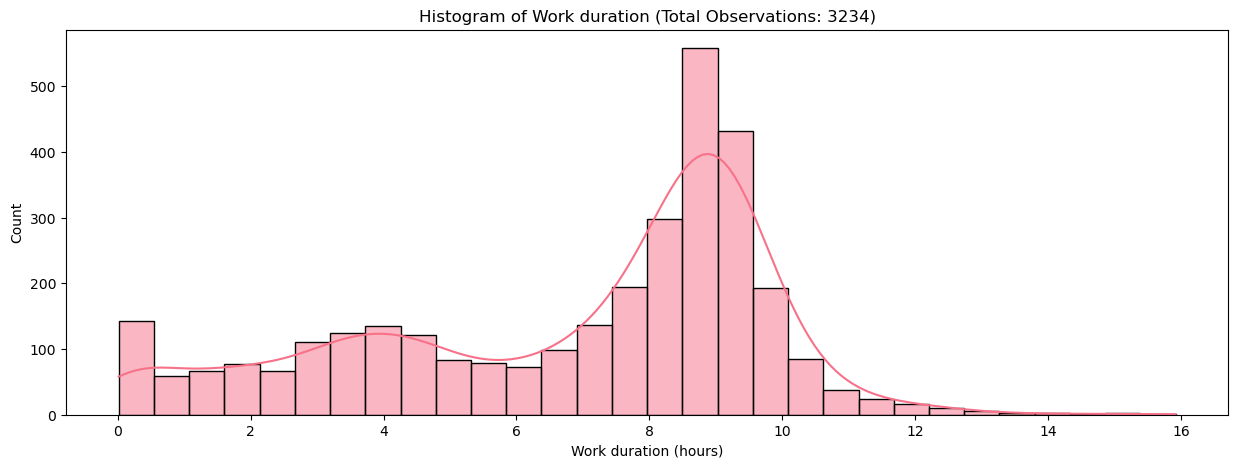

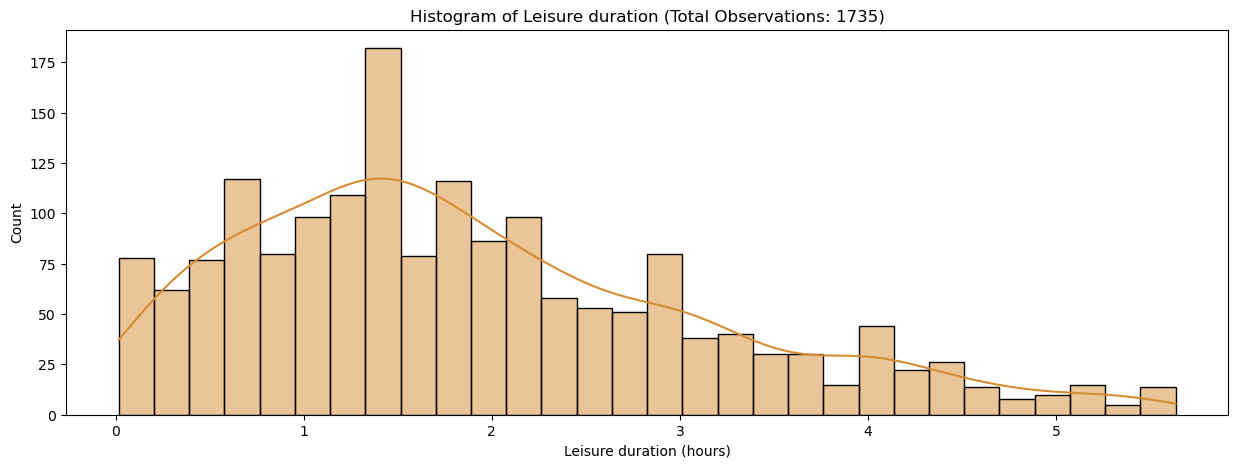

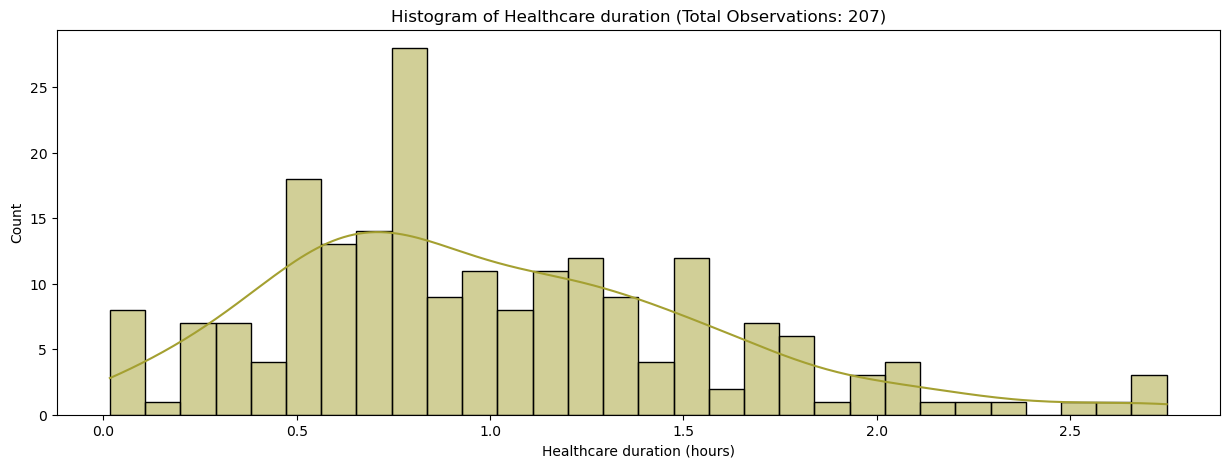

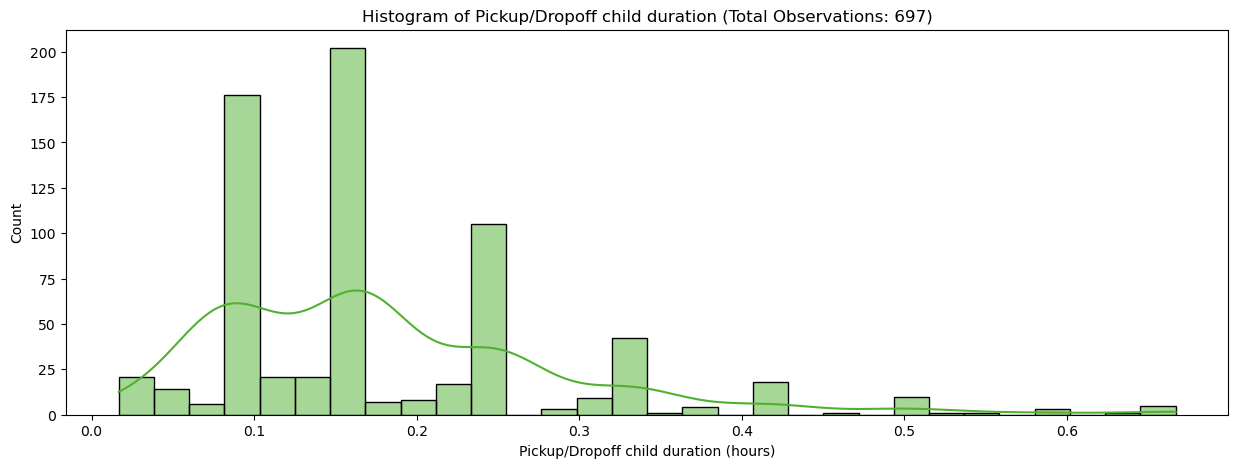

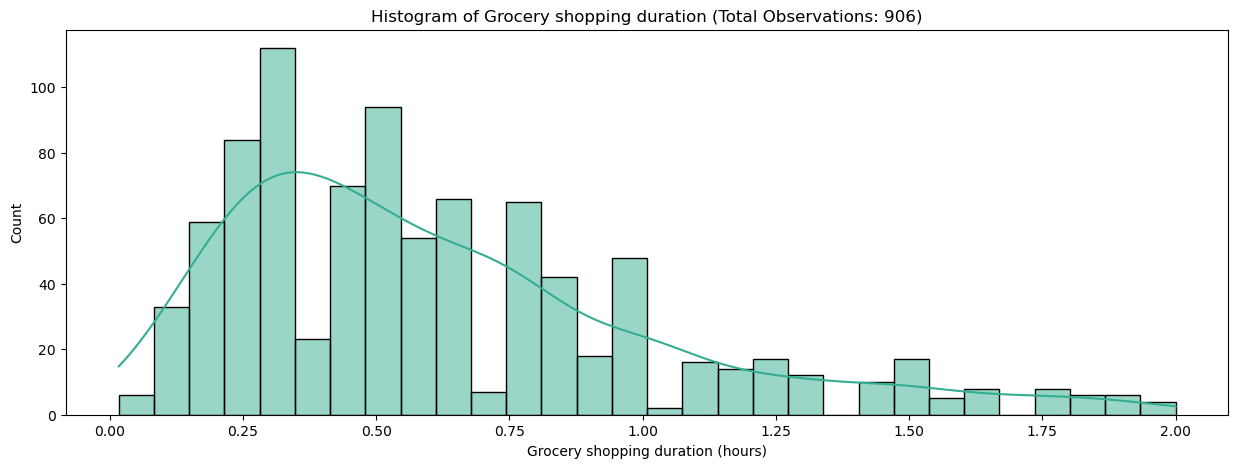

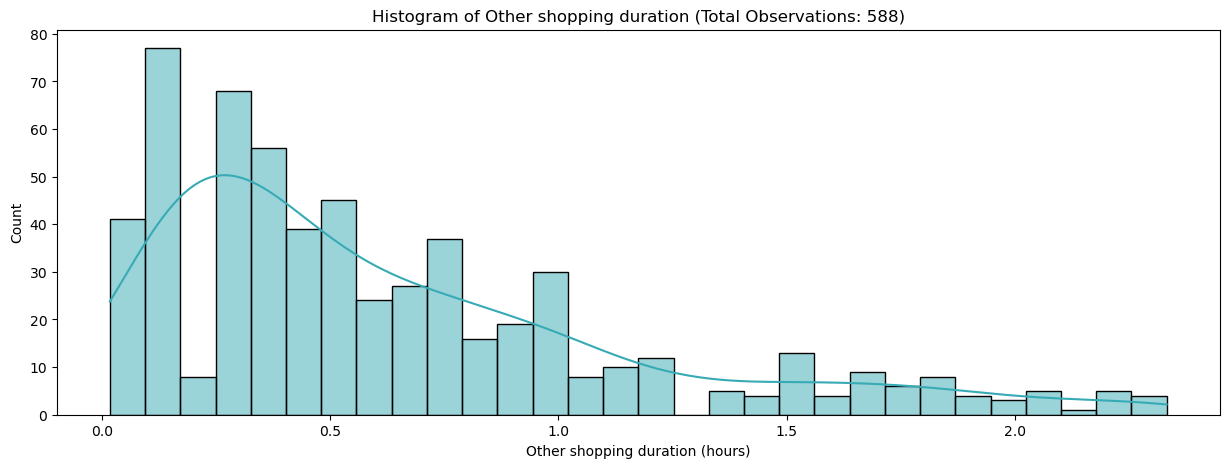

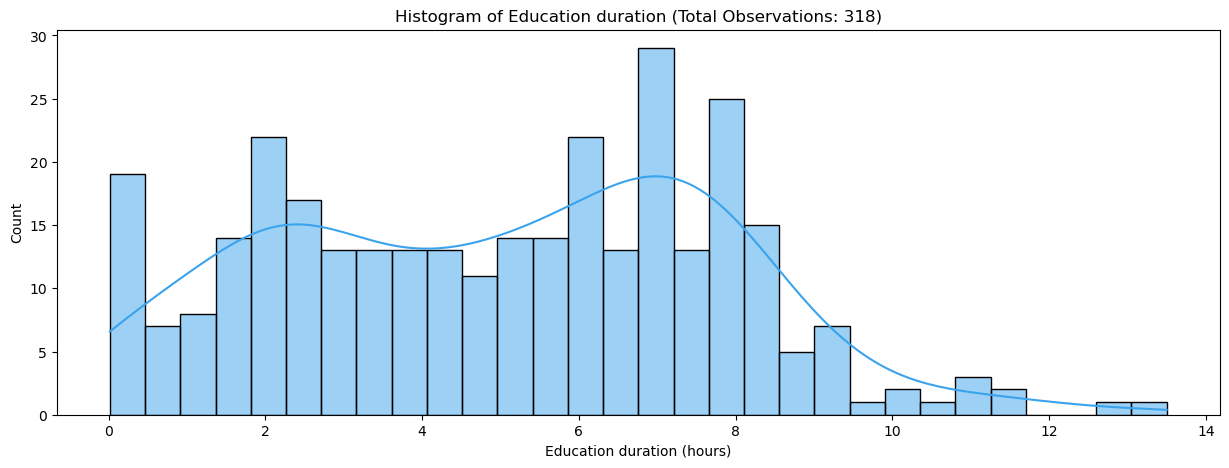

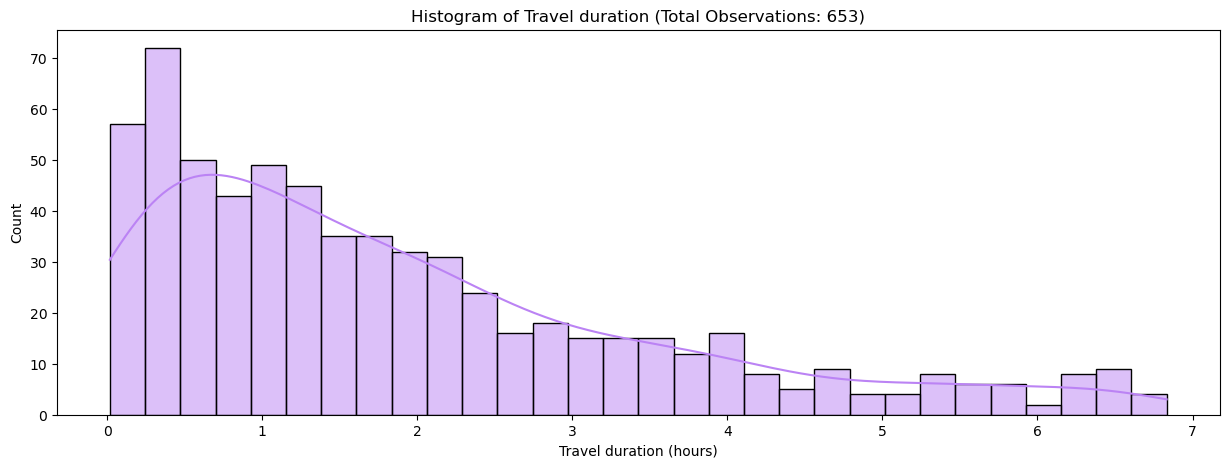

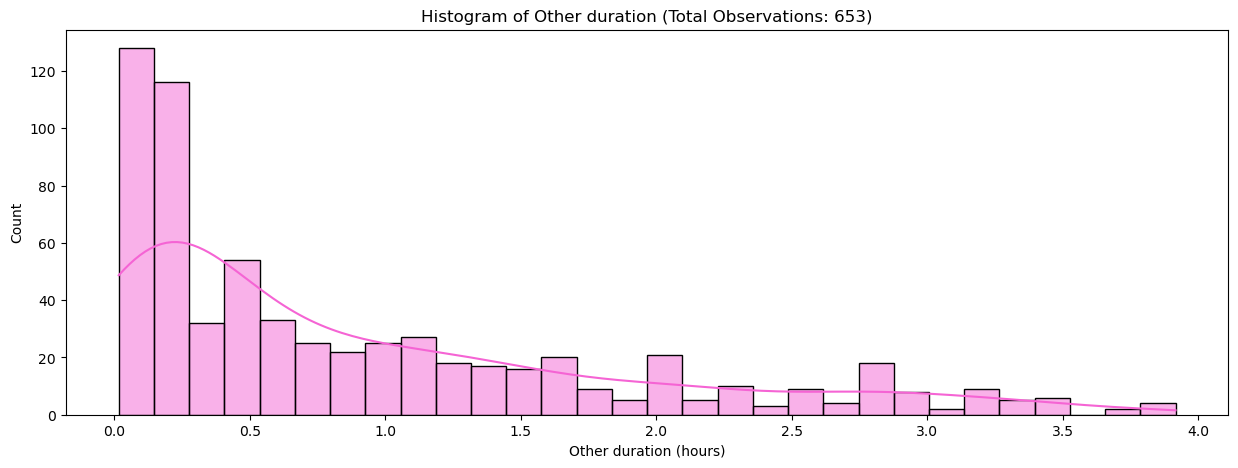

In [4]:
# Sort the dataframe by 'id' and 'activity_sequence'
df_activity = df_activity.sort_values(by=['id', 'activity_sequence'])

# Group by 'id' and then shift the 'start_time' up within each group
df_activity['next_start_time'] = df_activity.groupby('id')['start_time'].shift(-1)

# Create a dataframe to store activity, id, and duration
df_activity_duration = pd.DataFrame(columns=['activity', 'id', 'duration'])




# Append the computed durations for each purpose to df_activity_duration
purposes = [purpose for purpose in df_activity['purpose'].unique() if purpose != "Home"]
colors = sns.color_palette("husl", len(purposes))

# Compute activity duration for each purpose
for purpose in purposes:
    df_activity_duration = df_activity_duration.append(compute_activity_duration(df_activity, purpose))

# Plot the histogram of activity duration for each purpose
for index, purpose in enumerate(purposes):
    subset_df = df_activity_duration[df_activity_duration['activity'] == purpose]
    plot_activity_duration_histogram(subset_df, purpose, colors[index])


# Fitting a distribution to our data

Skipped plotting for: Pickup/Dropoff child


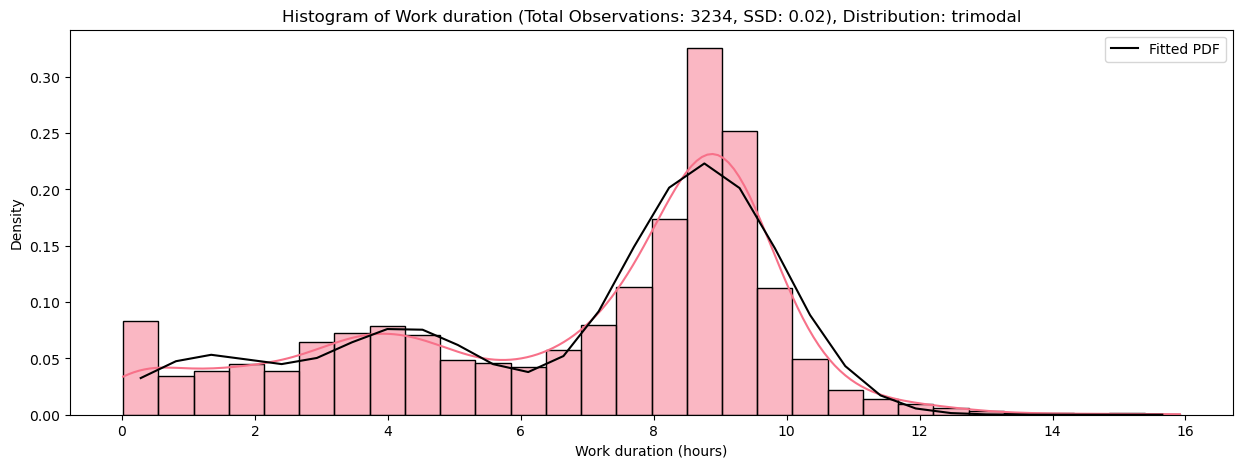

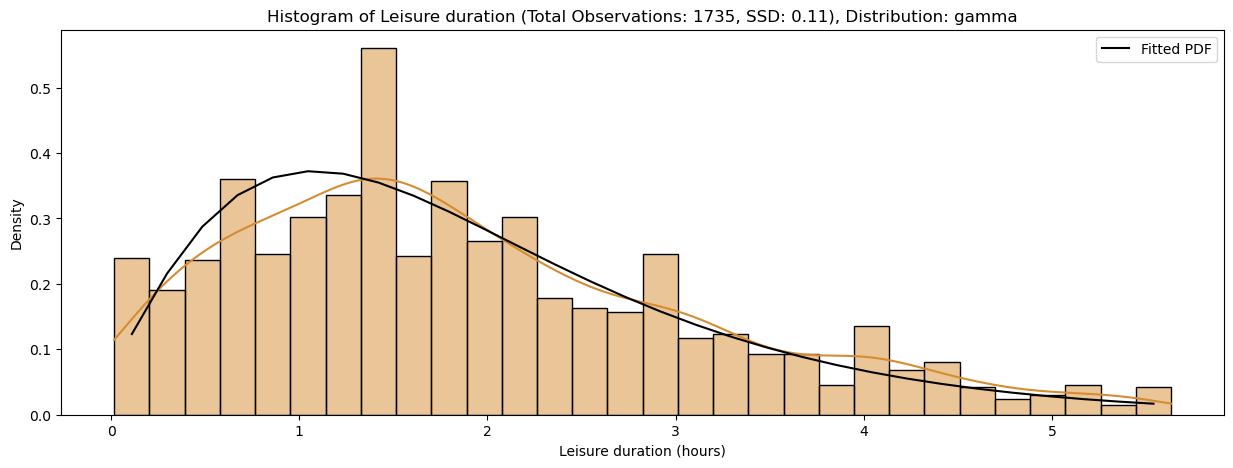

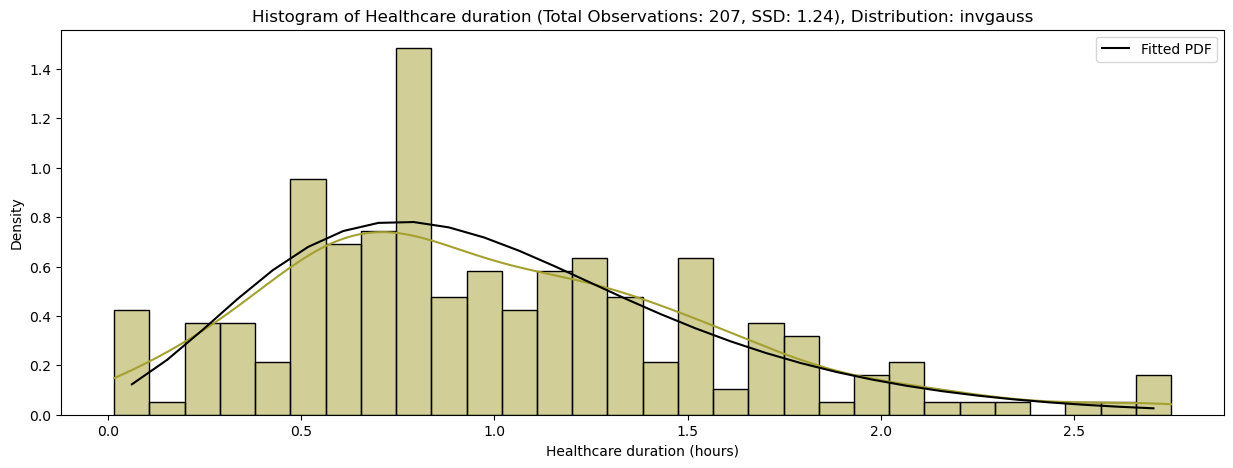

No distribution mapping found for purpose: Pickup/Dropoff child


<Figure size 1500x500 with 0 Axes>

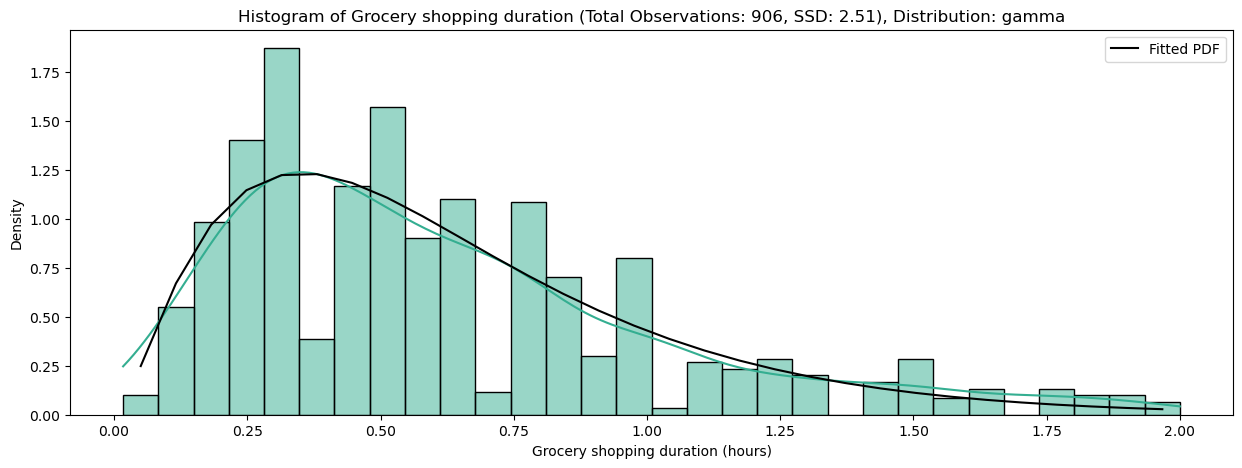

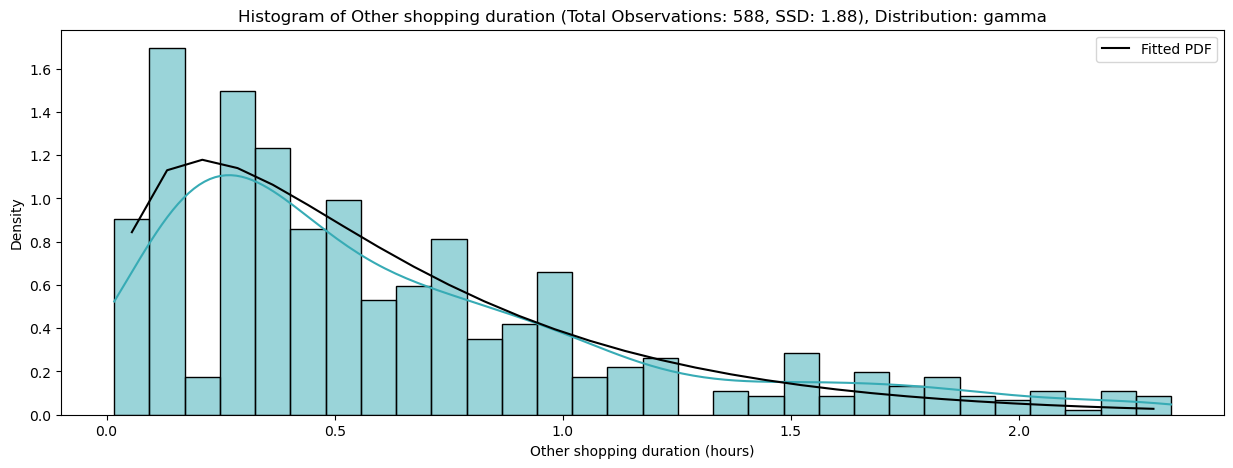

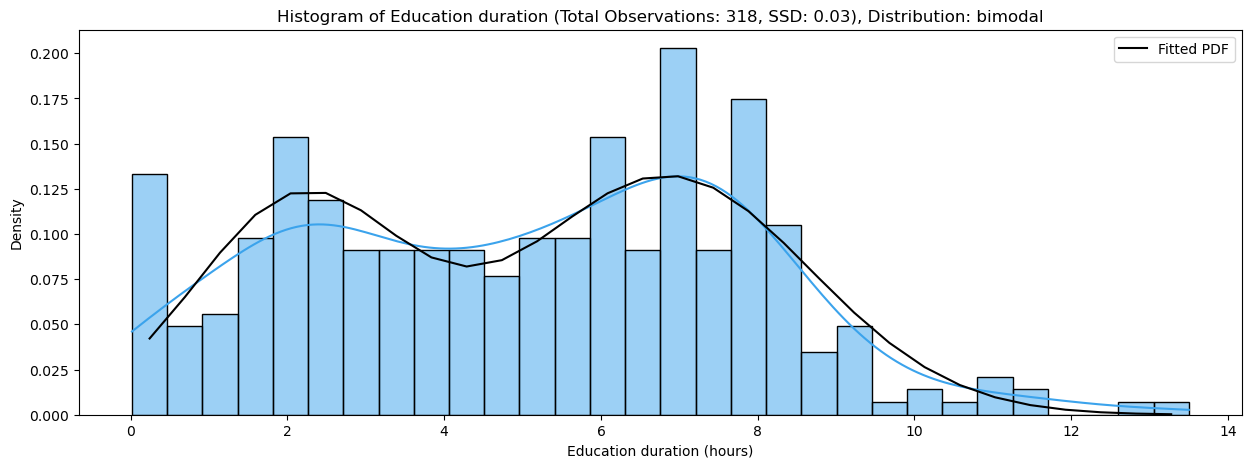

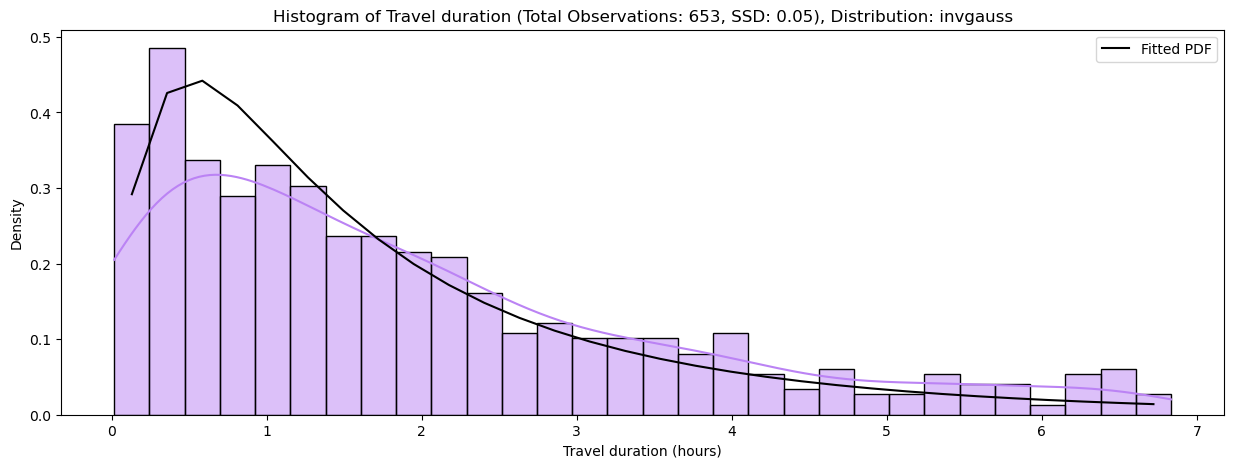

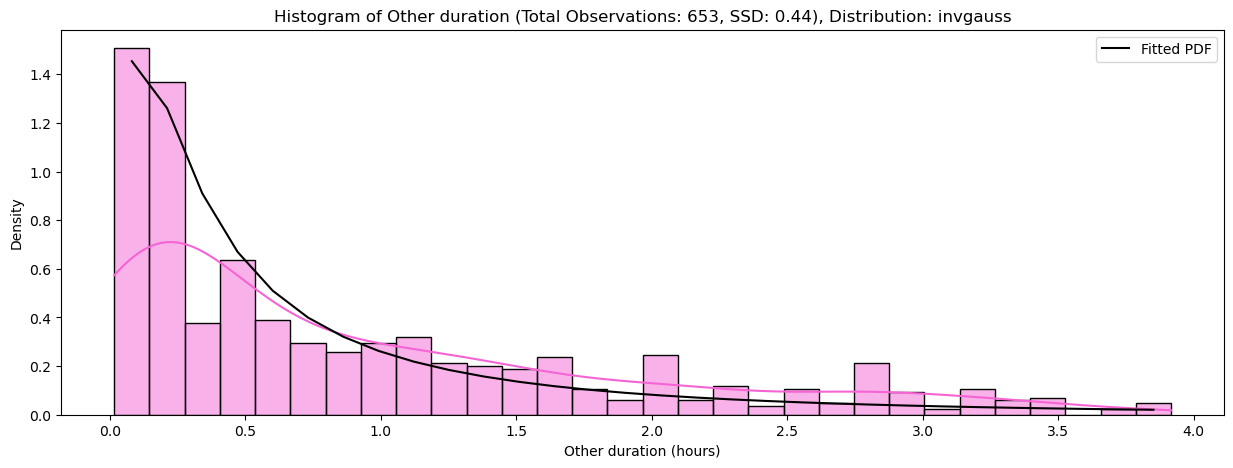

In [5]:
# Fit and plot distribution for each purpose
for index, purpose in enumerate(purposes):
    if purpose not in distribution_mapping:
        print(f"Skipped plotting for: {purpose}")
        continue
    subset_df = df_activity_duration[df_activity_duration['activity'] == purpose]

# Add parameters to params_dict
params_dict = {}

for index, purpose in enumerate(purposes):
    subset_df = df_activity_duration[df_activity_duration['activity'] == purpose]
    parameters = fit_and_plot(subset_df, purpose, colors[index])
    
    # Check if parameters are valid before adding to params_dict
    if parameters:
        params_dict[purpose] = {
            'distribution': distribution_mapping.get(purpose),
            'parameters': parameters
        }


# Drawing from the sample and plotting

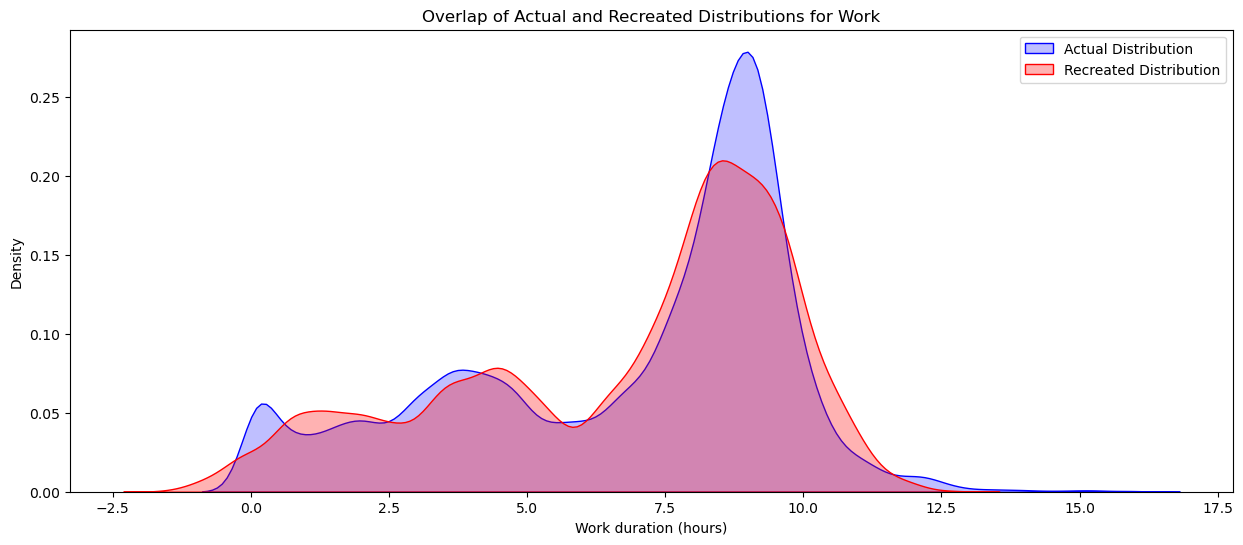

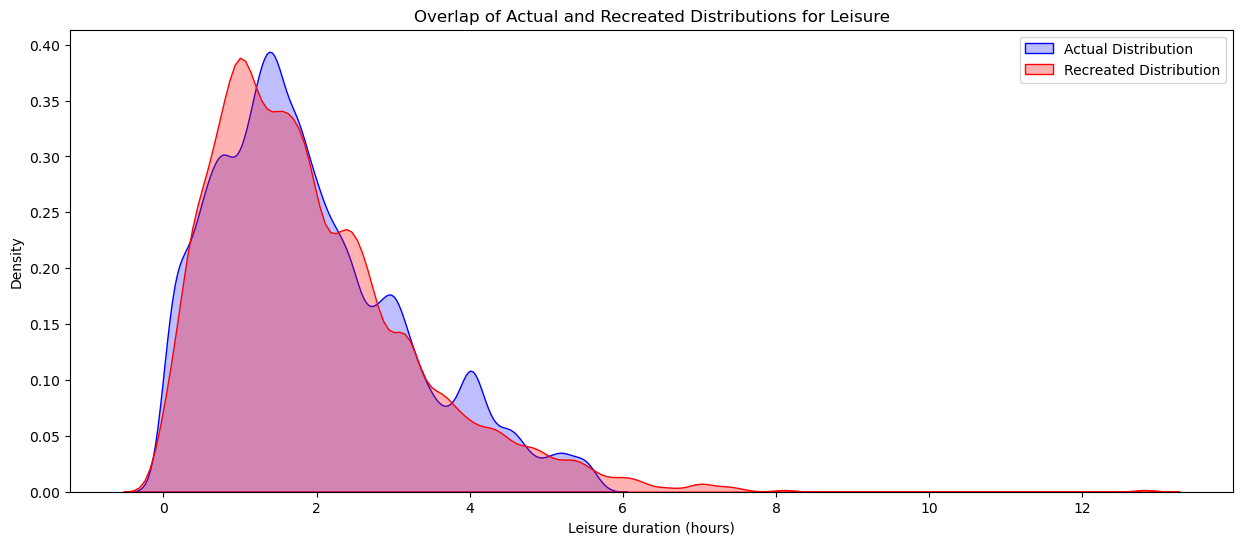

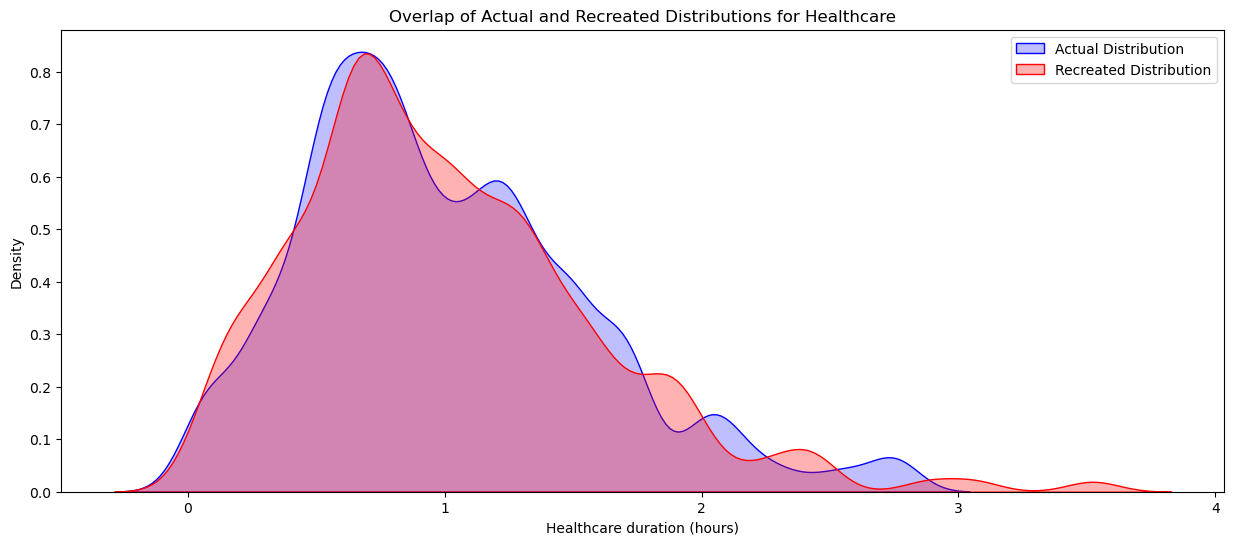

No parameters found for purpose: Pickup/Dropoff child
Failed to recreate distribution for Pickup/Dropoff child


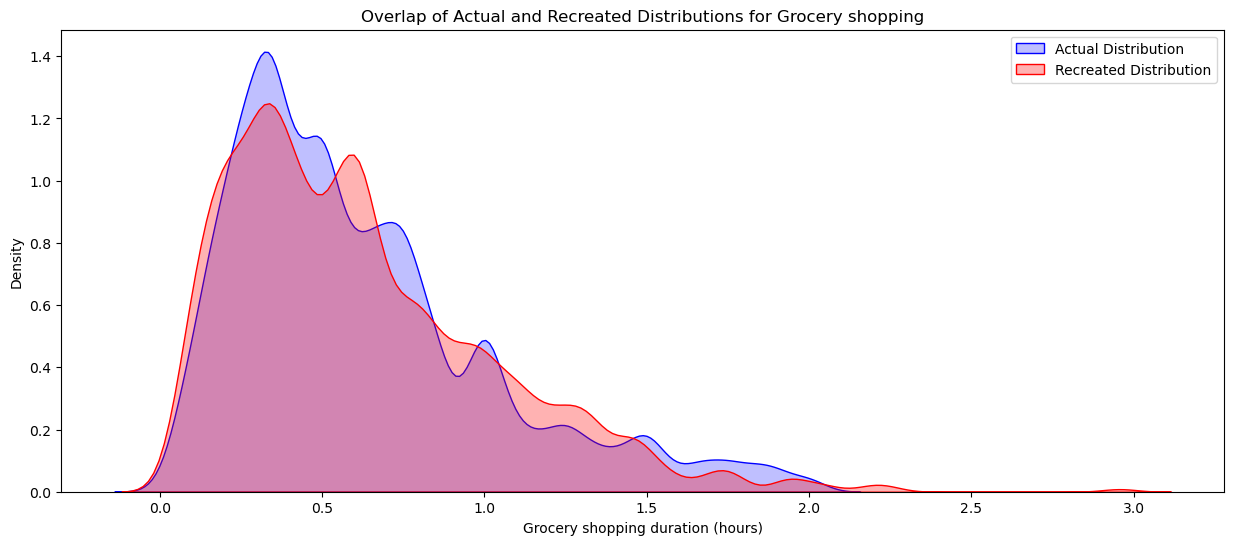

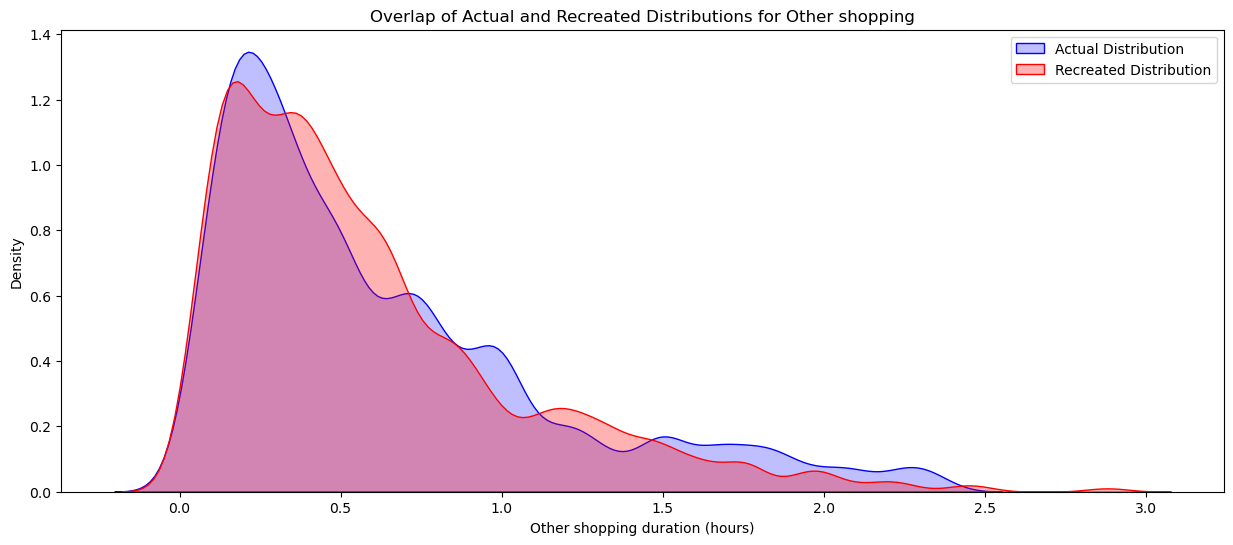

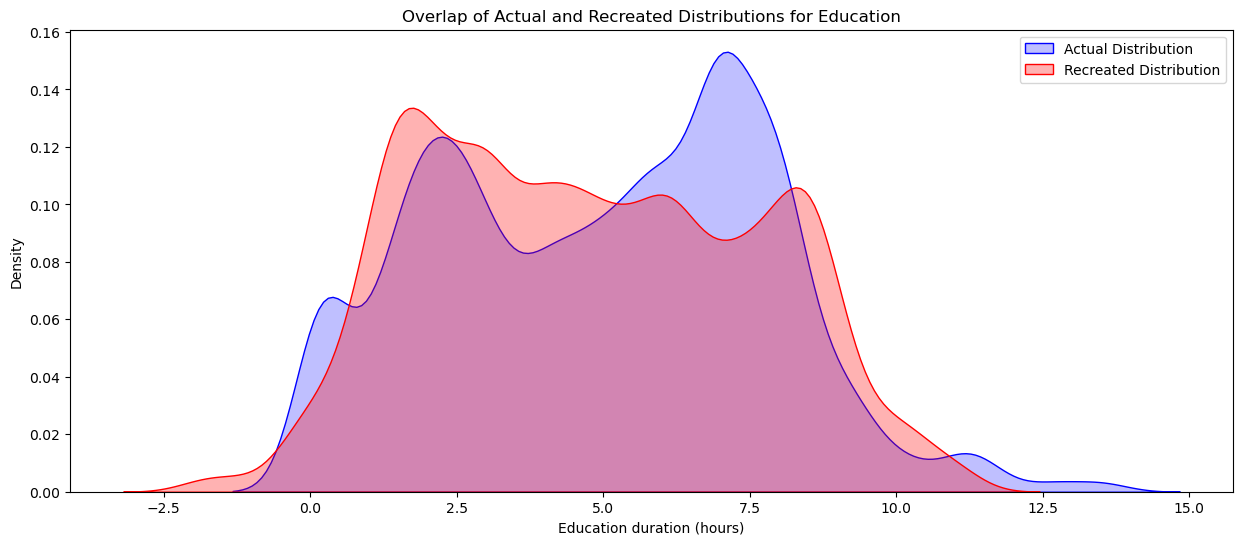

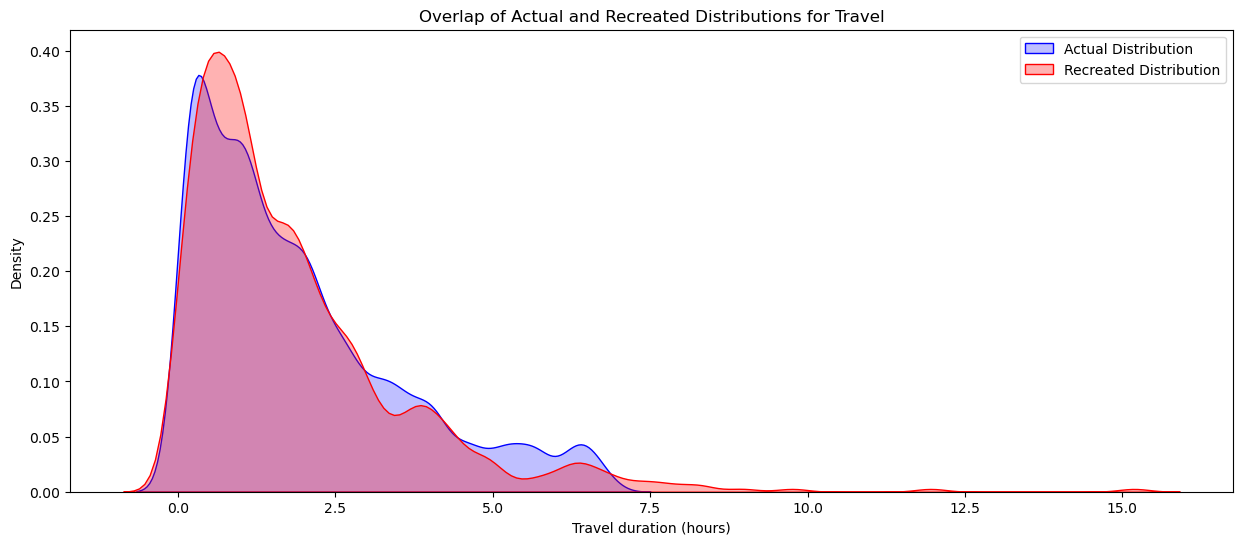

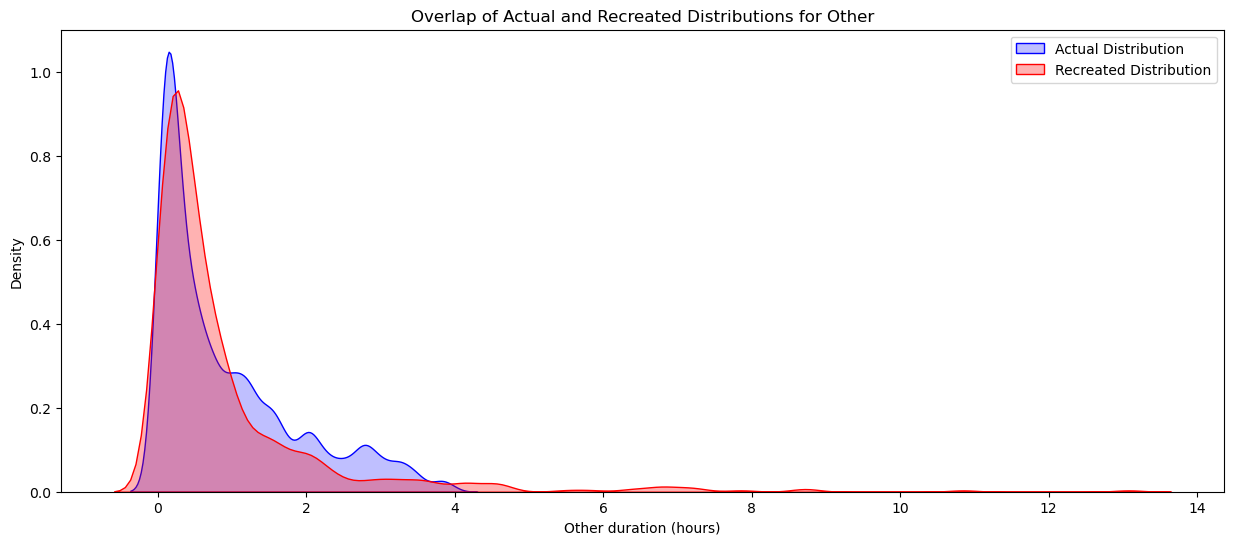

In [6]:
for purpose in purposes:
    plot_overlap(purpose, df_activity_duration, params_dict)

In [7]:
# Rename the columns using a dictionary
name_remap = {
    'Work': 'WORK',
    'Leisure': 'LEISURE',
    'Healthcare': 'HEALTHCARE',
    'Grocery shopping': 'GROCERY',
    'Other shopping': 'SHOPPING',
    'Education': 'EDUCATION',
    'Travel': 'TRAVEL',
    'Other': 'OTHER'
}

# Apply the remapping to params_dict
params_dict_renamed = {}
for purpose, params in params_dict.items():
    params_dict_renamed[name_remap[purpose]] = params

# Save params_dict_renamed to a JSON file


# Saving the distribution

In [8]:
# Save fitted_distributions to a json file using the custom encoder
with open('../models/DURATION_DIST.json', 'w') as f:
    json.dump(params_dict_renamed, f, cls=NumpyEncoder, indent=4)